## Iterative pre-whitening examples
### Ground-based data

This notebook provides an example for running an iterative pre-whitening (IPW) analysis for an RR Lyrae variable observed in multiple filters from the ground. 

We will perform the IPW on the MeerLICHT q-band data.

BONUS: Do the same for the other bands and compare the amplitudes.

For this notebook, you'll need to download: [ML_V02.csv](https://iacerasmus.github.io/ERASMUS2022/data/ML_V02.csv)

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pythia.timeseries.lombscargle import LS_periodogram
from pythia.timeseries.iterative_prewhitening import run_ipw



plt.rcParams.update({
    "text.usetex": True,
        "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams.update({
    "pgf.rcfonts": False,
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": "\n".join([
         r"\usepackage{amsmath}",
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
         r"\usepackage{cmbright}",
    ]),
})

plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18

In [2]:
df = pd.read_csv('../data/ML_V02.csv', usecols=['MJD', 'Filter', 'Mag_Opt', 'Magerr_Opt'])

First, we will work with the $q$-band data.

In order to make sure that we're not over or under exploring the data, we need to quantify:
   - 1) The frequency resolution allowed by the data: $f_{\rm Rayleigh} = \frac{1.5}{\Delta T}$, where $\Delta T$ is the total time base of the $q$-band light curve.
   - 2) The maximum frequency that we can sample up to, i.e. the Nyquist frequency: $f_{\rm Nyq}=\frac{1}{<\delta t>}$, where $<\delta t>$ is the median time-step in the light curve.


In [3]:
lc_q = df.loc[df['Filter']=='q']
times_q = lc_q.MJD.values
mags_q = lc_q.Mag_Opt.values
time_base = max(times_q)-min(times_q)
delta_freq = 1./time_base

delta_t = np.median(np.diff(times_q))
f_nyq = 0.5/delta_t

In [4]:
print('$q$-band:')
print('\t Total time-base: {:.2f} d'.format(time_base))
print('\t Frequency resolution: {:.5f} c/d'.format(delta_freq))
print('\t Nyquist Frequency: {:.5f} c/d'.format(f_nyq))

$q$-band:
	 Total time-base: 1737.11 d
	 Frequency resolution: 0.00058 c/d
	 Nyquist Frequency: 162.86645 c/d


Okay, so we can see that the data allows for a high frequency resolution $f_{\rm Rayleigh}$, and a high $f_{\rm Nyquist}$. 

Typically, we would want to oversample in frequency by a factor of 5-10 (we'll use 7). However, since we know ahead of time that the target is an RR Lyrae (spoiler alert), we don't need to explore super high frequencies. So, we'll simply assume $f_{\rm Nyquist}=50~{\rm d^{-1}}$.

Pythia allows for the user to specify the minimum and maximum frequency searched, as well as the oversampling factor in frequency that is used. Another thing to keep in mind is that you MUST remove the mean magnitude from your observations and center the data around zero. Pythia does not do this for you.

In [5]:
nu, amp = LS_periodogram(times_q, mags_q-np.median(mags_q), min=1.5*delta_freq, max=50., oversample_factor=7.)

#### You don't have to calculate these values each time, pythia is clever enough to figure out the frequency resolution, nyquist frequency, etc., by itself.

Keep in mind that periodogram calculations scale as $N \log\left( N\right)$, where $N$ is the number of data points. So although this particular example ran quickly, if you use a 4-year long {\it Kepler} short-cadence light curve, you'll be sitting here for a while and your laptop will likely not be happy. 

But, in any case, let's plot our results.

<IPython.core.display.Javascript object>


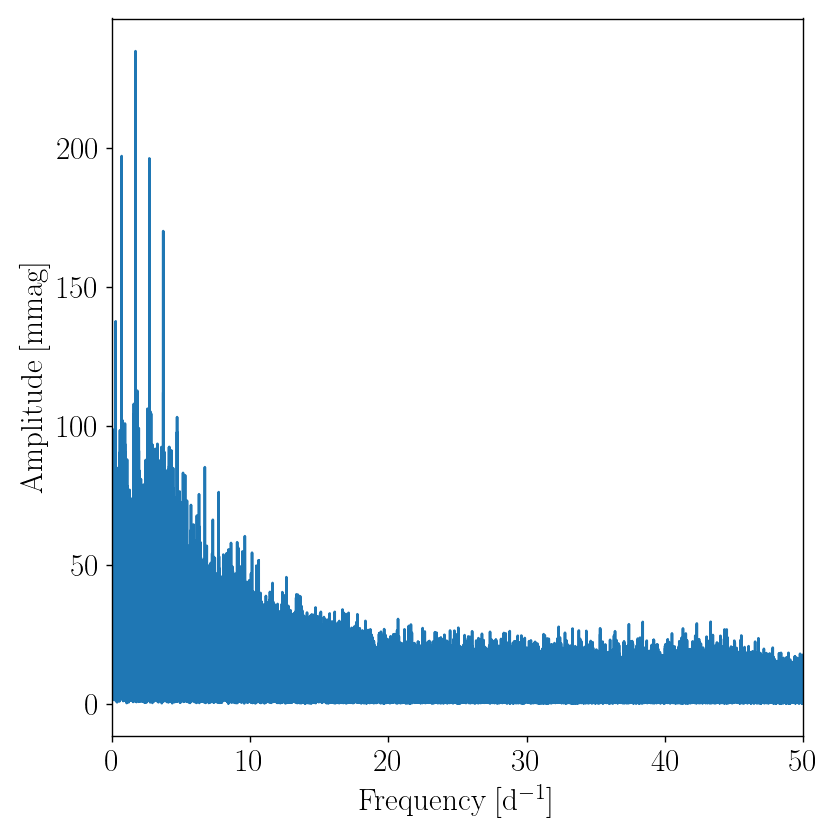

In [6]:
fig, ax = plt.subplots(1,1,figsize=(6.69,6.69),num=1)
ax.plot(nu, amp*1000.)
ax.set_xlabel(r'${\rm Frequency~[d^{-1}]}$',fontsize=18)
ax.set_ylabel(r'${\rm Amplitude~[mmag]}$',fontsize=18)
ax.set_xlim(0.,50.)
fig.tight_layout()

Well that looks familiar! Let's identify the frequency of maximum amplitude.

In [7]:
f_max = nu[np.argmax(amp)]
period_max = 1./f_max
print('The frequency of maximum amplitude occurs at {:.4f} c/d'.format(f_max))

The frequency of maximum amplitude occurs at 1.7178 c/d


We can now phase fold our light curve on this frequency using the relation: 
    $\phi = \left( \frac{t-t_0}{P_{\rm max}} \right) \mod 1 = \left( \left( t-t_0\right ) f_{\rm max} \right) \mod 1 $

In [8]:
def time_to_phase(times, frequency, t0=0.):
    return ((times-t0)*frequency) % 1.

<IPython.core.display.Javascript object>


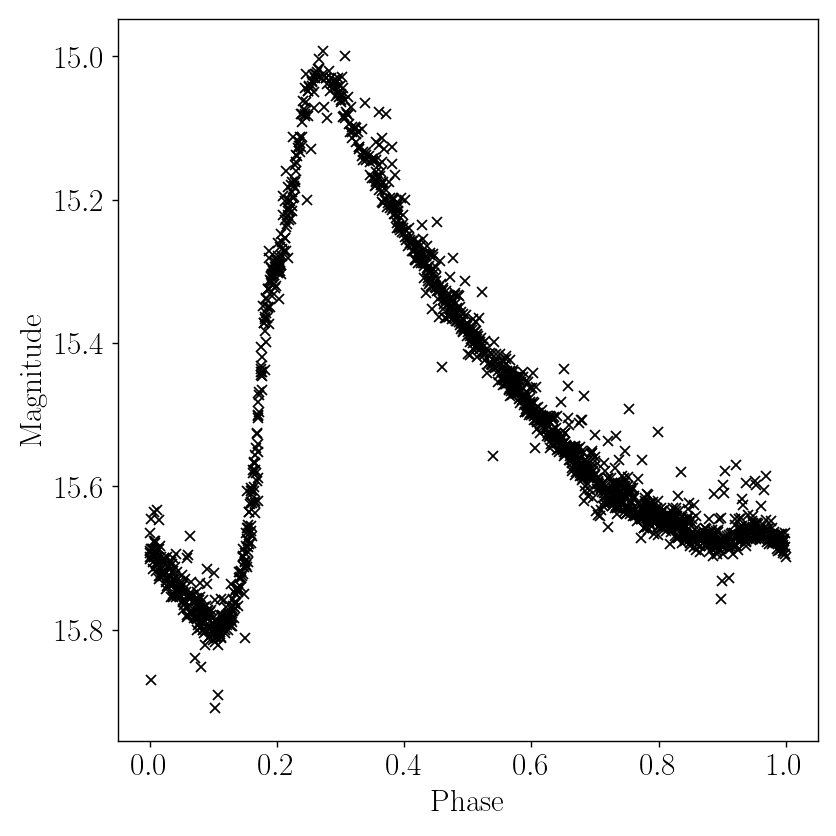

In [9]:
fig, ax = plt.subplots(1,1,figsize=(6.69,6.69),num=2)
ax.plot(time_to_phase(times_q, f_max, t0=0.), mags_q, 'kx')
ax.set_xlabel(r'${\rm Phase}$',fontsize=18)
ax.set_ylabel(r'${\rm Magnitude}$',fontsize=18)
ax.set_ylim(ax.get_ylim()[::-1])
fig.tight_layout()


In this case, we've identified the correct frequency manually. 

However, we haven't removed this signal from the data yet. 

Instead of doing this manually as well, let's use Pythia, which comes with an iterative pre-whitening function (__run_ipw__). This function takes the times, flux/magnitude data, as well as the data uncertainties, and any keyword arguments that the __LS_periodogram__ function accepts. 


In [11]:
yerr = 0.0005* np.ones_like(times_q)
residuals, model, offsets, \
frequencies, amplitudes, \
phases, stop_criteria, noise_final = run_ipw(times_q,mags_q-np.mean(mags_q), yerr, maxiter=4, max=50.)


Individually optimised sinusoids: 
Sinusoid 0: Frequency: 1.7178003598635474 Amplitude: 0.24383036296522997 Phase: 0.836316483539454
Sinusoid 1: Frequency: 3.4356445939307028 Amplitude: 0.11985175859036044 Phase: -2.2465677246311926
Sinusoid 2: Frequency: 5.153550741116852 Amplitude: 0.08158854840104801 Phase: 1.1893736156860812
Sinusoid 3: Frequency: 6.87139790888568 Amplitude: 0.048547646719323274 Phase: -1.3664343450450447



[0.27176796 0.12800441 0.08534864 0.04937349]


Excellent -- the code ran wihtout any hiccups. Now let's check the residuals to see what's left over!

<IPython.core.display.Javascript object>


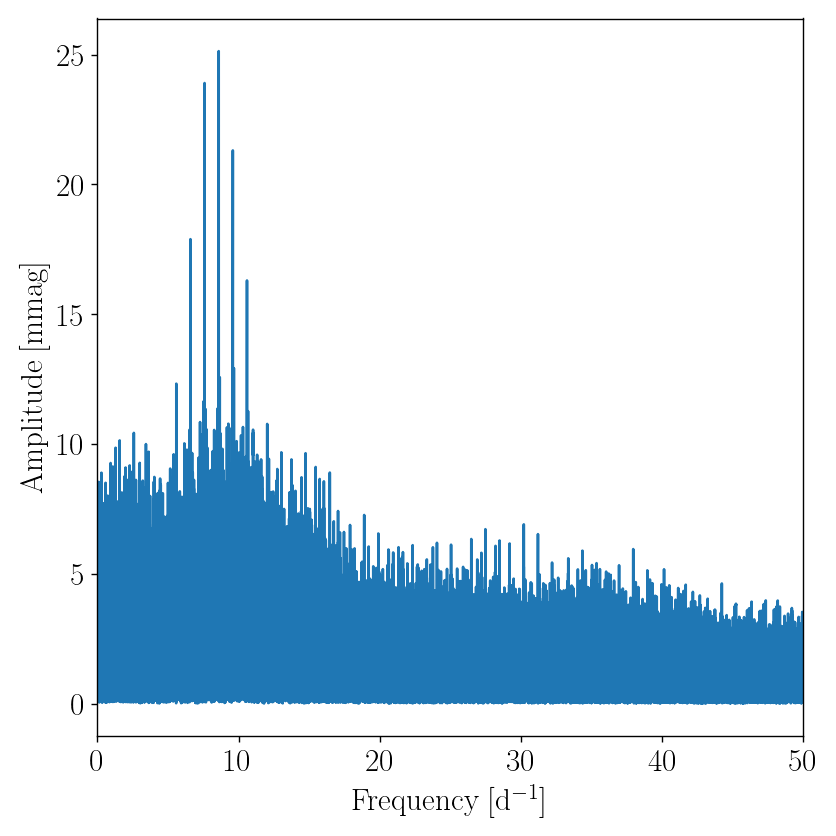

In [13]:
nu_res, amp_res = LS_periodogram(times_q, residuals, max=50.)
fig, ax = plt.subplots(1,1,figsize=(6.69,6.69),num=3)
ax.plot(nu_res, amp_res*1000.)
ax.set_xlabel(r'${\rm Frequency~[d^{-1}]}$',fontsize=18)
ax.set_ylabel(r'${\rm Amplitude~[mmag]}$',fontsize=18)
ax.set_xlim(0.,50.)
fig.tight_layout()

Turns out that there's a lot of signal left over. This highlights the limitations of IPW for highly non-sinusoidal signals. 

If we phase-fold the signal on the original period, we can see that there's a lot of harmonic signal leftover.

<IPython.core.display.Javascript object>


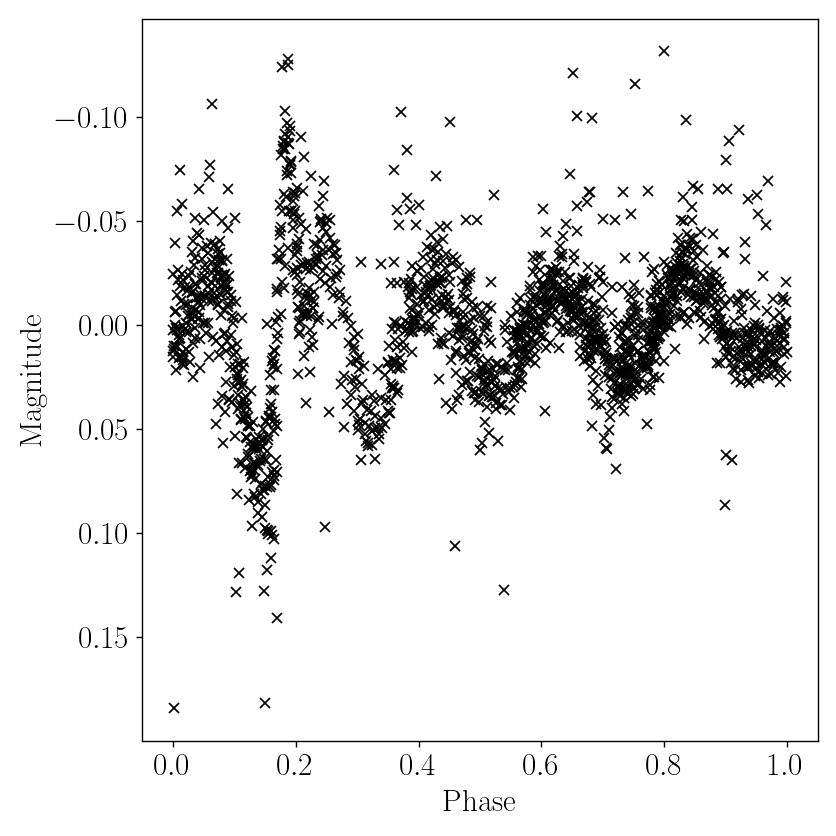

In [14]:
fig, ax = plt.subplots(1,1,figsize=(6.69,6.69),num=4)
ax.plot(time_to_phase(times_q, f_max, t0=0.), residuals, 'kx')
ax.set_xlabel(r'${\rm Phase}$',fontsize=18)
ax.set_ylabel(r'${\rm Magnitude}$',fontsize=18)
ax.set_ylim(ax.get_ylim()[::-1])
fig.tight_layout()